In [1]:
from typing import List
import matplotlib.pyplot as plt
from src.repository.surebet_repository import SurebetRepository
from src.repository.game_repository import GameRepository
from src.genetic.arbitrage import CrossOverEnum, Population
from src.util import ExportadorDeGraficos, PickleSerializer
from datetime import datetime, timedelta
import math
import pandas as pd
game_repository = GameRepository()
repository = SurebetRepository()

### Parâmetros para execução do experimento

In [2]:
n_generations = 150
n_individuals = 50
mutation_rate = 0.05
crossover_rate = 0.98
budget=100
crossover=CrossOverEnum.UNIFORM_CROSSOVER

### Método para gerar intervalos entre dois tempos (horas)

In [3]:
def gera_intervalos(start="2023-09-02 14:00:00", end="2023-09-02 15:00:00", freq=5) -> List[str]:
    
    start_time = datetime.strptime(start, "%Y-%m-%d %H:%M:%S")
    end_time = datetime.strptime(end, "%Y-%m-%d %H:%M:%S")
    
    interval = timedelta(minutes=freq)
    
    current_time = start_time
    intervals = [start]
    while current_time < end_time:
        current_time += interval
        intervals.append(current_time.strftime('%Y-%m-%d %H:%M:%S'))
    
    return intervals

<h3>Métodos auxiliares para plot, consulta ao banco e munipulação dos dados</h3>

In [4]:
def get_teams(ids):
    return game_repository.get_teams(ids)

In [5]:
from src.genetic.arbitrage import Individual

def decode_individual(individual: Individual, population: Population, individual_label, report_header, path, teams_dict: dict, verbose=True):
    profit = individual.fitness[0]
    number_of_surebets_chosen = sum([i[0] for i in individual.chromosome])
    surebets_selected = []
    surebets_selected_summary = []
        
    for gene, arbitrage in zip(individual.chromosome, individual.arbitrages):
        if gene[0] == 1:
            surebets_selected.append((f'Partida: {teams_dict.get(arbitrage.game_id)}', f'Casa 1: {arbitrage.bookmaker_key_OVER[:3]}', f'Casa 2: {arbitrage.bookmaker_key_UNDER[:3]}', f'Valor apostado R$ {round(gene[1] * population.budget, 2)}', f'Lucro R$ {((gene[1]*population.budget)*(arbitrage.profit/100)):,.2f}', f'{arbitrage.profit:,.2f}%'))
    
    if verbose:
        print(individual_label)
        print(f'Número de surebets escolhidas: {number_of_surebets_chosen}')
        print('Surebets selecionadas:')
        for i in surebets_selected:
            print(i)
    
        print(f'Lucro total: R$ {profit:,.2f}')
        print('-------------------------------------------------------------------------------------------------------------------------------------------------------')
    
    with open(path, 'a') as file:
        if report_header is not None:
            file.write(report_header)

        file.write(f'{individual_label}\n')
        file.write(f'Número de surebets escolhidas: {number_of_surebets_chosen}\n')
        file.write('Surebets selecionadas:\n')
        for i in surebets_selected:
            file.write(str(i)+'\n')
        file.write(f'Lucro total: R$ {profit:,.2f}\n')
        file.write('-------------------------------------------------------------------------------------------------------------------------------------------------------\n')
        
    

### Evolução da fronteira de pareto (3 fronteiras)

In [6]:
def paretos_frontier_evolution_plot(population: Population, export: ExportadorDeGraficos):
    plt.figure()
    plt.title('Evolução da Fronteira de Pareto')
    plt.xlabel('Lucro')
    plt.ylabel('Distribuição de surebets')
    colors = ['#7634BB', '#2BF063', '#9DC3E6']
    path = export.data_hora_atual + '/' + 'pareto_evolution.png'
    evolution_points = len(population.evolution_front)
    aux = population.evolution_front[0], population.evolution_front[evolution_points//2], population.evolution_front[-1]

    aux = [(h, sorted(f, key=lambda x :x[1])) for h, f in aux]
    count = 0
    for hypervolume, front, in aux:
        x = [i[0] for i in front]
        y = [i[1] for i in front]
        plt.plot(x, y, marker='o', label=f'Hv = {hypervolume:,.4f}')
        plt.scatter(x, y, color=colors[count])
        count += 1
    plt.legend()
    plt.savefig(path)
    plt.close()

def export_pareto_frontier_evolution(population: Population, export: ExportadorDeGraficos):
    evolution_frontier_x = list()
    evolution_frontier_y = list()
    generation_plot = [0, population.n_generations - 1, population.best_frontier-1]
    for generation, front in population.pareto_history_front_normalized:
        x = [i[0] for i in front]
        y = [i[1] for i in front]
        if generation in generation_plot:
            export.plot(x, y, generation+1)
            evolution_frontier_x.append(x)
            evolution_frontier_y.append(y)
    paretos_frontier_evolution_plot(population, export)



### Hypervolume por gerações

In [7]:
def hypervolume_per_generation(population: Population, export: ExportadorDeGraficos):    
    export.hypervolume_plot(population)

### Fronteira de pareto com 3 indivíduos selecionados

In [8]:
def pick_up_individuals(front):   
    front_fitness = list({tuple(i.fitness) for i in front})  # Remove os itens repetidos
    OPTIMIZE_PROFIT = -1
    OPTIMIZE_MIDDLE = ((len(front_fitness) // 2) - 1)
    OPTIMIZE_DISPERSATION = 0
    
    front_sorted = sorted(front, key=lambda x: x.fitness[0])
    front_fitness = sorted(front_fitness, key=lambda x: x[0])
    
    aux_individuals_selected = front_fitness[OPTIMIZE_PROFIT], front_fitness[OPTIMIZE_MIDDLE], front_fitness[OPTIMIZE_DISPERSATION]  # Seleciona os 3 indivíduos (Aqui só tem os fitness)
    selected = []
    
    # Método para descobrir qual a é o indivíduo(dentro da fronteira de pareto que possui vários objetos) que possui o fitness escolhido anteriormente
    for i in aux_individuals_selected:
        for individual in front_sorted:
            if list(i) == individual.fitness:
                selected.append(individual)
                break

    return front_sorted, selected


def normalize(front, high_fitness_evaluated):
    max_profit = high_fitness_evaluated[0]
    max_dispersation = high_fitness_evaluated[1]
    for i in front:
        profit_normalized = i.fitness[0] / max_profit
        dispersation_normalized = i.fitness[1] / max_dispersation
        i.fitness_normalized = [profit_normalized, dispersation_normalized]
        

def paretos_frontier_plot(front, selected_individuals, path):
    plt.figure()
    plt.xlim(0, 1.05)
    plt.ylim(0, 1.05)
    plt.title(f'Fronteira de pareto')
    plt.xlabel('Lucro')
    plt.ylabel('Distribuição de surebets')
    plt.scatter([i.fitness_normalized[0] for i in front], [i.fitness_normalized[1] for i in front])
    plt.scatter([i.fitness_normalized[0] for i in selected_individuals], [i.fitness_normalized[1] for i in selected_individuals], color='#2BF063')
    plt.plot([i.fitness_normalized[0] for i in front], [i.fitness_normalized[1] for i in front], color='red', linewidth=1, linestyle='-')
    # plt.show()
    plt.savefig(path)
    plt.close()


def plot_3_individuals_selected_front(population: Population, export: ExportadorDeGraficos):
    if population.best_frontier is None:
        export.calculate_hypervolume(population)

    frontier = population.pareto_history_front[population.best_frontier][1]
    
    front_sorted, individuals_selected = pick_up_individuals(frontier)
    
    normalize(front_sorted, population.high_fitness_evaluated)
    normalize(individuals_selected, population.high_fitness_evaluated)
    
    path = export.data_hora_atual + '/3_individuals_selected.png'
    paretos_frontier_plot(front_sorted, individuals_selected, path)

    return individuals_selected

### Salva objeto em binário com pickle

In [9]:
def export_pickle(population: Population, export: ExportadorDeGraficos):
    PickleSerializer.save(population, f'{export.data_hora_atual}/pickle.pkl')

### Exporta dados (hypervolume, fronteiras de pareto e binário) 

In [10]:
def run_scenario(start_date = '2023-09-02 14:00:00', end_date = '2023-09-02 14:05:00', verbose=True, count=0):
    export = ExportadorDeGraficos()
    
    arbitrages = repository.find_all_unique_between(start_date, end_date)
    population = Population(n_generations=n_generations, n_individuals=n_individuals, mutation_rate=mutation_rate, crossover_rate=crossover_rate, 
                            budget=budget, crossover_strategy=crossover, arbitrages=arbitrages)
    
    
    # Salvando binário de population
    export_pickle(population, export)
    
    # Gerando hypervolume por geração
    hypervolume_per_generation(population, export)
    
    # Gerando fronteira de pareto com 3 indivíduos selecionados (Melhor lucro, melhor distribuição e intermediário)
    individuals_picked_up = plot_3_individuals_selected_front(population, export)
    
    # Gerando evolução da fronteira de pareto
    export_pareto_frontier_evolution(population, export)
    
    # Pegando os nomes dos times
    teams_dict = get_teams([i.game_id for i in arbitrages])
    
         
    labels = ['Otimização do Lucro', 'Otimização do lucro e quantidade de surebets', 'Otimização da quantidade de surebets']
    folder = export.data_hora_atual
    start = datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S').strftime('%H:%M')
    end = datetime.strptime(end_date, '%Y-%m-%d %H:%M:%S').strftime('%H:%M')
    date_event = datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S').strftime('%d/%m/%Y')
    path = f"{folder}/report_{start}_{end}.txt"

    report_header = f"""************************************************************* RELATÓRIO DO EXPERIMENTO *************************************************************

[Data]: {date_event}
[Intervalo das surebets]: {start} to {end}
[Geração da Fronteira de Pareto]: {population.best_frontier + 1}º geração
[Banca]: R$ {population.budget:,.2f}

"""
    for label, individual in zip(labels, individuals_picked_up):
        decode_individual(individual, population, label, report_header, path, teams_dict, verbose)
        report_header = None


### variação do lucro dentro de intervalos

In [36]:
def plot_interval_profit(x, y, ylim, title, export: ExportadorDeGraficos, export_name = ''):
    plt.figure()
    plt.title(title)
    plt.ylim(0, math.ceil(ylim/5)*5)
    plt.xlabel('Intervalo de tempo')
    plt.ylabel('Lucro')
    plt.xticks(rotation=90)
    plt.scatter(x, y)
    plt.plot(x, y, linewidth=1, linestyle='-')
    plt.savefig(export.data_hora_atual + '/' + export_name, bbox_inches='tight')
    plt.close()
    
    
def plot_interval_profit_intersection(x, y, labels, ylim, title, export: ExportadorDeGraficos, export_name = ''):
    plt.figure()
    plt.title(title)
    plt.ylim(0, math.ceil(ylim/5)*5)
    plt.xlabel('Intervalo de tempo')
    plt.ylabel('Lucro')
    plt.xticks(rotation=90)

    markers = ['o', 's', 'x']

    for count, (y_data, label, marker) in enumerate(zip(y, labels, markers)):
        plt.scatter(x, y_data, marker=marker, label=label)
        plt.plot(x, y_data, linewidth=1, linestyle='-')
    
    plt.legend()
    plt.savefig(export.data_hora_atual + '/' + export_name, bbox_inches='tight')
    plt.close()
    
def interval_profit(start_date='2023-09-02 14:00:00', end_date='2023-09-02 16:00:00'):
    export = ExportadorDeGraficos()
    
    intervals = gera_intervalos(start_date, end_date)
    x_values = []
    y_values = [[0], [0], [0]]

    PROFIT = 0
    DISPERSATION = 1
    PROFIT_DISPERSATION = 2
    
    for i in range(len(intervals)-1):
        start = intervals[i] 
        end = intervals[i+1]
        
        arbitrages = repository.find_all_unique_between(start, end)
        if len(arbitrages) > 1:
            population = Population(n_generations=n_generations, n_individuals=n_individuals, mutation_rate=mutation_rate, crossover_rate=crossover_rate, 
                                    budget=budget, crossover_strategy=crossover, arbitrages=arbitrages)
        
            if population.best_frontier is None:
                export.calculate_hypervolume(population)
            
            best_front: List[Individual] = population.pareto_history_front[population.best_frontier][1]
            list_sorted = sorted(best_front, key=lambda x: x.fitness[0])
            
            max_profit = list_sorted[-1].fitness[0]
            max_dispersation = list_sorted[0].fitness[0]
            profit_dispersation = list_sorted[(len(list_sorted) // 2) - 1].fitness[0]
            
            values = [max_profit, max_dispersation, profit_dispersation]
        else:
            values = [0, 0, 0]
            
        x_values.append(f'{datetime.strptime(start, "%Y-%m-%d %H:%M:%S").strftime("%H:%M")} - {datetime.strptime(end, "%Y-%m-%d %H:%M:%S").strftime("%H:%M")}')

        y_values[PROFIT].append(values[PROFIT])  # Guardando lucro
        y_values[DISPERSATION].append(values[DISPERSATION])  # Guardando lucro
        y_values[PROFIT_DISPERSATION].append(values[PROFIT_DISPERSATION])  # Guardando lucro
    
    max_value = max(y_values[PROFIT][1:])

    plot_interval_profit(x_values, y_values[PROFIT][1:], max_value,f'Variação do lucro: Otimização do lucro', export, 'profit_variation')
    plot_interval_profit(x_values, y_values[DISPERSATION][1:], max_value,f'Variação do lucro: Distribuição eficiente', export, 'profit_variation_distribution')
    plot_interval_profit(x_values, y_values[PROFIT_DISPERSATION][1:], max_value,f'Variação do lucro: Equilíbrio entre os dois objetivos', export, 'profit_variation_equilibrium')
    
    labels = ['Otimização do Lucro', 'Distribuição Eficiente', 'Equilíbrio entre os objetivos']
    
    plot_interval_profit_intersection(x_values, [y_values[PROFIT][1:], y_values[DISPERSATION][1:], y_values[PROFIT_DISPERSATION][1:]], labels, max_value, 'Variação do lucro para os 3 objetivos', export, 'profit_variation_3_objective')
    
    data_to_save = {'x_value': x_values, 'y_value': y_values}
    PickleSerializer.save(data_to_save, f'{export.data_hora_atual}/profit_variation_interval.pkl')


### Gera gráfico lucro acumulado

In [34]:
def accumulated_profit(start_date='2023-09-02 14:00:00', end_date='2023-09-02 15:00:00'):
    export = ExportadorDeGraficos()
    
    intervals = gera_intervalos(start_date, end_date)
    x_values = []
    y_values = [[0], [0], [0]]

    PROFIT = 0
    DISPERSATION = 1
    PROFIT_DISPERSATION = 2

    for i in range(len(intervals)-1):
        start = intervals[i] 
        end = intervals[i+1]
        arbitrages = repository.find_all_unique_between(start, end)

        if len(arbitrages) > 1:
            population = Population(n_generations=n_generations, n_individuals=n_individuals, mutation_rate=mutation_rate, crossover_rate=crossover_rate, 
                                    budget=budget, crossover_strategy=crossover, arbitrages=arbitrages)
    
            if population.best_frontier is None:
                export.calculate_hypervolume(population)
            
            best_front: List[Individual] = population.pareto_history_front[population.best_frontier][1]
            list_sorted = sorted(best_front, key=lambda x: x.fitness[0])
            
            max_profit = list_sorted[-1].fitness[0]
            max_dispersation = list_sorted[0].fitness[0]
            profit_dispersation = list_sorted[(len(list_sorted) // 2) - 1].fitness[0]
            
            values = [max_profit, max_dispersation, profit_dispersation]
        else:
            values = [0, 0, 0]
            
        x_values.append(f'{datetime.strptime(start, "%Y-%m-%d %H:%M:%S").strftime("%H:%M")} - {datetime.strptime(end, "%Y-%m-%d %H:%M:%S").strftime("%H:%M")}')

        y_values[PROFIT].append(y_values[PROFIT][-1] + values[PROFIT])  # acumulando o último valor
        y_values[DISPERSATION].append(y_values[DISPERSATION][-1] + values[DISPERSATION])  # acumulando o último valor
        y_values[PROFIT_DISPERSATION].append(y_values[PROFIT_DISPERSATION][-1] + values[PROFIT_DISPERSATION])  # acumulando o último valor
        
    max_value = max(y_values[PROFIT][1:])
    plot_interval_profit(x_values, y_values[PROFIT][1:], max_value, 'Lucro acumulado: Otimização do lucro', export, 'accumulated_profit')
    plot_interval_profit(x_values, y_values[DISPERSATION][1:], max_value, 'Lucro acumulado: Distribuição eficiente', export, 'distribuition_accumulated_profit')
    plot_interval_profit(x_values, y_values[PROFIT_DISPERSATION][1:], max_value, 'Lucro acumulado: Equilíbrio entre os objetivos', export, 'equilibrium_accumulated_profit')
    labels = ['Otimização do Lucro', 'Distribuição Eficiente', 'Equilíbrio entre os objetivos']
    
    plot_interval_profit_intersection(x_values, [y_values[PROFIT][1:], y_values[DISPERSATION][1:], y_values[PROFIT_DISPERSATION][1:]], labels, max_value, 'Lucro acumulado para os 3 objetivos', export, 'accumulated_profit_3_objective')
    
    data_to_save = {'x_value': x_values, 'y_value': y_values}
    PickleSerializer.save(data_to_save, f'{export.data_hora_atual}/accumulated_profit.pkl')

### Lucro Acumulado para o cenário 02/09/2023 14:00 às 15:00

In [27]:
accumulated_profit(start_date='2023-09-02 14:00:00', end_date='2023-09-02 15:00:00')

### Experimento para o cenário 24/09/2023 15:00 às 16:00

In [23]:
# run_scenario(start_date='2023-09-24 15:15:00', end_date='2023-09-24 15:20:00', verbose=False)
# accumulated_profit(start_date='2023-09-24 15:00:00', end_date='2023-09-24 16:00:00')
# interval_profit(start_date='2023-09-24 15:00:00', end_date='2023-09-24 16:00:00')

### Variação do lucro para o cenário 02/09/2023 14:00 às 15:00

In [ ]:
interval_profit(start_date='2023-09-02 14:00:00', end_date='2023-09-02 15:00:00')

<h3> Cenários mês de setembro </h3>
<img src="images/surebets_setembro.png" width="75%">
<br> <br>
<img src="images/surebets_02_setembro.png" width="75%">

### Cenário 02/09/2023 14:20 às 14:25

In [ ]:
# run_scenario(start_date='2023-09-02 14:20:00', end_date='2023-09-02 14:25:00', verbose=False)

### Código para gerar lista de surebets de um intervalo

In [ ]:
import pandas as pd
start_date='2023-09-02 14:20:00'
end_date='2023-09-02 14:25:00'
arbitrages = repository.find_all_unique_between(start_date, end_date)

teams = get_teams([i.game_id for i in arbitrages])

data = {
    # 'Time': [teams.get(surebet.game_id) for surebet in arbitrages],
    'Casa de aposta 1': [surebet.bookmaker_key_OVER for surebet in arbitrages],
    'Casa de aposta 2': [surebet.bookmaker_key_UNDER for surebet in arbitrages],
    'odd_OVER': [surebet.odd_OVER for surebet in arbitrages],
    'odd_UNDER': [surebet.odd_UNDER for surebet in arbitrages],
    'Lucro': [surebet.profit for surebet in arbitrages]
}

df = pd.DataFrame(data)


# Exibindo o DataFrame
print(df.to_string())


### Código para gerar gráfico das surebets (incluindo as persistentes ao longo do tempo)

Monday        7
Tuesday      15
Wednesday    13
Thursday      2
Friday       19
Saturday     62
Sunday       62
Name: Dia da semana, dtype: int64


<Figure size 640x480 with 0 Axes>

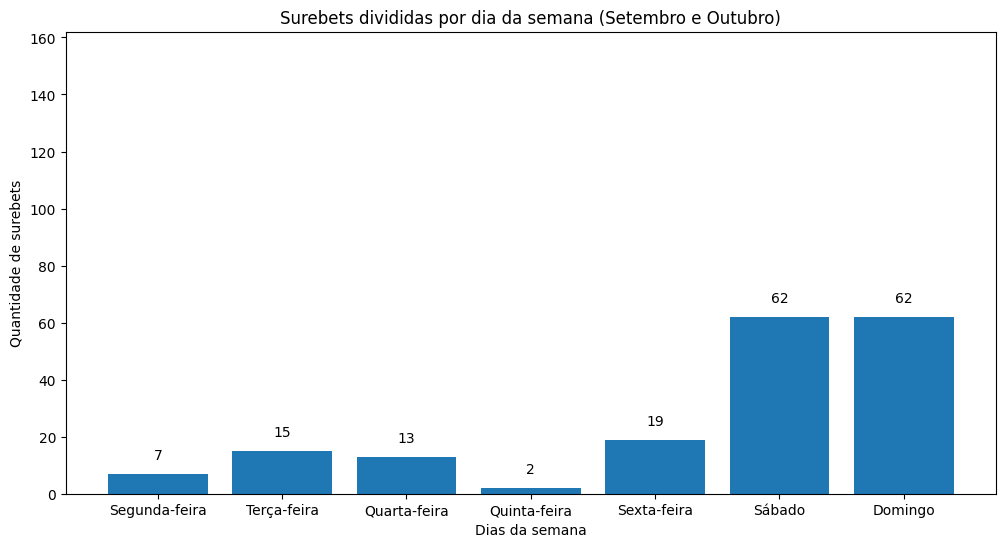

In [28]:
def plot_dataset(x, y, ylim, title, xlabel, export: ExportadorDeGraficos, export_name = ''):
    plt.figure()
    largura_figura = 12  # Ajuste a largura
    altura_figura = 6    # Ajuste a altura
    plt.figure(figsize=(largura_figura, altura_figura))
    plt.title(title)
    plt.ylim(0, ylim + 100)
    plt.xlabel(xlabel)
    plt.ylabel('Quantidade de surebets')
    plt.bar(x, y)
    

    
    for i, valor in enumerate(y):
        plt.text(i, valor + 5, str(valor), ha='center')
    
    # plt.show()
    plt.savefig(export.data_hora_atual + '/' + export_name)
    plt.close()

dias_semana = {
    'Monday': 'Segunda-feira',
    'Tuesday': 'Terça-feira',
    'Wednesday': 'Quarta-feira',
    'Thursday': 'Quinta-feira',
    'Friday': 'Sexta-feira',
    'Saturday': 'Sábado',
    'Sunday': 'Domingo'
}

find_all = repository.find_all_between(start_date='2023-01-01 00:00:00', end_date='2023-08-31 23:59:59')
# find_all = repository.find_all_between(start_date='2023-09-01 00:00:00', end_date='2023-10-31 23:59:59')

teams = get_teams([i.game_id for i in find_all])

data = {
    'Time': [teams.get(surebet.game_id) for surebet in find_all],
    'Casa de aposta 1': [surebet.bookmaker_key_OVER for surebet in find_all],
    'Casa de aposta 2': [surebet.bookmaker_key_UNDER for surebet in find_all],
    'odd_OVER': [surebet.odd_OVER for surebet in find_all],
    'odd_UNDER': [surebet.odd_UNDER for surebet in find_all],
    'Data': [surebet.last_update_OVER for surebet in find_all],
    'Lucro': [surebet.profit for surebet in find_all]
}

df = pd.DataFrame.from_dict(data)
df['Dia da semana'] = df['Data'].dt.day_name()

ordem_personalizada = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}

x_days = []
y_count = []
    
contagem_ordenada = df['Dia da semana'].value_counts().sort_index(key=lambda x: x.map(ordem_personalizada))

for day, count in contagem_ordenada.items():
    x_days.append(dias_semana.get(day))
    y_count.append(count)

plot_dataset(x_days, y_count, max(y_count), 'Surebets divididas por dia da semana (Setembro e Outubro)', 'Dias da semana', ExportadorDeGraficos())

January         0
February        0
March           0
April          17
May            51
June            5
July           13
August         94
September    1500
October       429
November        0
December        0
Name: mes, dtype: int64


<Figure size 640x480 with 0 Axes>

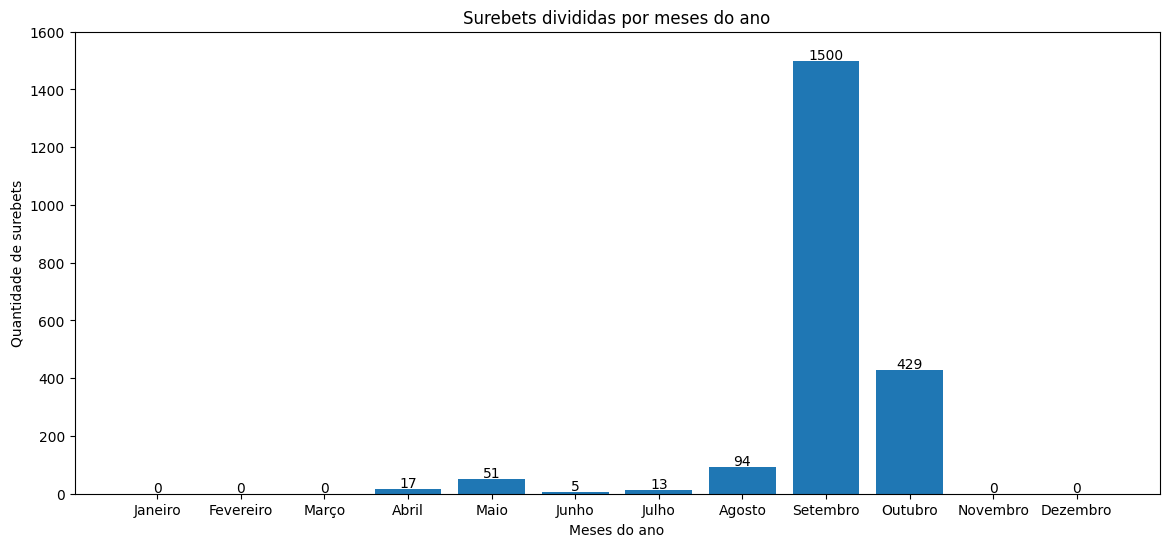

In [27]:

import calendar

meses = {
    'January': 'Janeiro',
    'February': 'Fevereiro',
    'March': 'Março',
    'April': 'Abril',
    'May': 'Maio',
    'June': 'Junho',
    'July': 'Julho',
    'August': 'Agosto',
    'September': 'Setembro',
    'October': 'Outubro',
    'November': 'Novembro',
    'December': 'Dezembro'
}

find_all = repository.find_all()

data = {
    'Data': [surebet.last_update_OVER for surebet in find_all],
}

df = pd.DataFrame.from_dict(data)
df['mes'] = df['Data'].dt.month_name()

x = []
y = []
    
quantidade_surebet = df['mes'].value_counts().reindex(list(calendar.month_name[1:]), fill_value=0)
for month, count in quantidade_surebet.items():
    x.append(meses.get(month))
    y.append(count)

plot_dataset(x, y, max(y), 'Surebets divididas por meses do ano', 'Meses do ano', ExportadorDeGraficos())

BETONLINEAG      54
MATCHBOOK      1337
NORDICBET       186
ONEXBET         576
PINNACLE        963
UNIBET_EU      1078
WILLIAMHILL      24
dtype: int64


<Figure size 640x480 with 0 Axes>

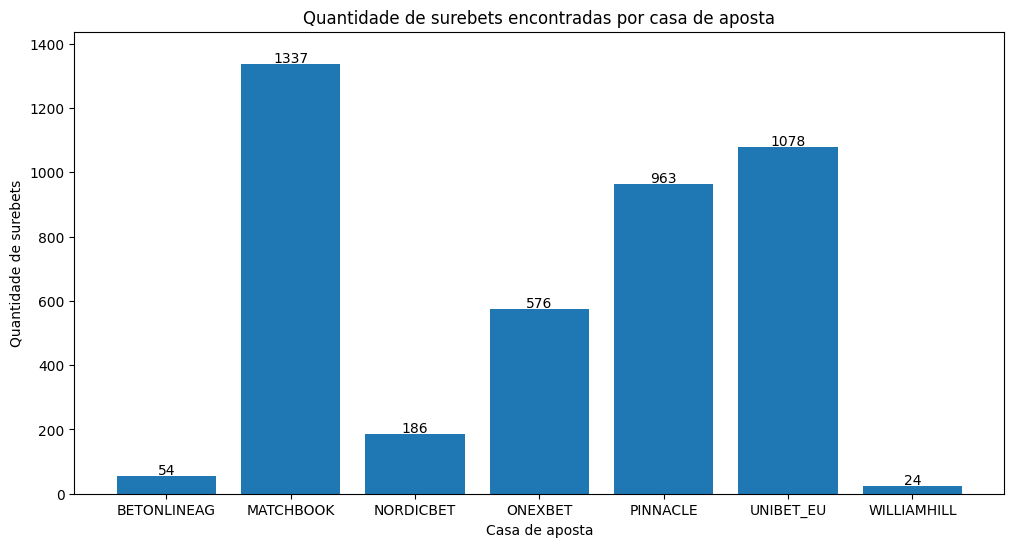

In [30]:
def plot_dataset(x, y, ylim, title, export: ExportadorDeGraficos, export_name = ''):
    plt.figure()
    largura_figura = 12  # Ajuste a largura
    altura_figura = 6    # Ajuste a altura
    plt.figure(figsize=(largura_figura, altura_figura))
    plt.title(title)
    plt.ylim(0, ylim + 100)
    plt.xlabel('Casa de aposta')
    plt.ylabel('Quantidade de surebets')
    plt.bar(x, y)



    for i, valor in enumerate(y):
        plt.text(i, valor + 5, str(valor), ha='center')

    plt.show()
    # plt.savefig(export.data_hora_atual + '/' + export_name)
    plt.close()

find_all = repository.find_all()

data = {
    'Casa de aposta 1': [surebet.bookmaker_key_OVER for surebet in find_all],
    'Casa de aposta 2': [surebet.bookmaker_key_UNDER for surebet in find_all],
    'Data': [surebet.last_update_OVER for surebet in find_all],
}

df = pd.DataFrame.from_dict(data)
total = df['Casa de aposta 1'].value_counts() + df['Casa de aposta 2'].value_counts()

x = []
y = []
     
print(total)
for book, count in total.items():
    x.append(book)
    y.append(count)

plot_dataset(x, y, max(y), 'Quantidade de surebets encontradas por casa de aposta', ExportadorDeGraficos())



### Cenário 02/09/2023 14:00 às 15:00

In [37]:
# run_scenario(start_date='2023-09-02 14:20:00', end_date='2023-09-02 14:25:00', verbose=False)

# accumulated_profit(start_date='2023-09-02 14:00:00', end_date='2023-09-02 15:00:00')
interval_profit(start_date='2023-09-02 14:00:00', end_date='2023-09-02 15:00:00')

### Cenário 24/09/2023 15:00 às 16:00

In [40]:
run_scenario(start_date='2023-09-24 15:15:00', end_date='2023-09-24 15:20:00', verbose=False)
# accumulated_profit(start_date='2023-09-24 15:00:00', end_date='2023-09-24 16:00:00')
# interval_profit(start_date='2023-09-24 15:00:00', end_date='2023-09-24 16:00:00')

### Cenário 01/10/2023 15:00 às 16:00

In [39]:
run_scenario(start_date='2023-10-01 15:45:00', end_date='2023-10-01 15:50:00', verbose=False)
# accumulated_profit(start_date='2023-10-01 15:00:00', end_date='2023-10-01 16:00:00')
# interval_profit(start_date='2023-10-01 15:00:00', end_date='2023-10-01 16:00:00')

### Cenário 07/10/2023 14:15 às 14:20

In [38]:
run_scenario(start_date='2023-10-07 14:15:00', end_date='2023-10-07 14:20:00', verbose=False)
# accumulated_profit(start_date='2023-10-07 14:00:00', end_date='2023-10-07 15:00:00')
# interval_profit(start_date='2023-10-07 14:00:00', end_date='2023-10-07 15:00:00')